In [1]:
#import libraries
import pandas as pd
print('pandas: %s' % pd.__version__)

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 150)

import numpy as np
print('geopandas: %s' % np.__version__)

# Tensorflow / Keras
import tensorflow as tf # used to access argmax function
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense # for creating regular densely-connected NN layer.
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout # for adding Concolutional and densely-connected NN layers.
from tensorflow.keras import layers

# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

import decimal
from decimal import Decimal

import keras 
import tensorflow as tf
from tensorflow.keras.layers import Dropout,BatchNormalization,Conv2D,MaxPooling2D,Dense,Flatten
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from keras import callbacks
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense # for creating regular densely-connected NN layer.
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout,MaxPooling2D # for adding Concolutional and densely-connected NN layers.
from tensorflow.keras import layers

from pathlib import Path  

from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.preprocessing import OrdinalEncoder # for encoding labels
from keras.models import load_model
from sklearn.preprocessing import StandardScaler



pandas: 1.5.0
geopandas: 1.23.2
Tensorflow/Keras: 2.10.0
pandas: 1.5.0
numpy: 1.23.2


In [2]:
model = load_model("/Users/paolo/Documents/TC_old/data/model_1l_512n_relu_dropout_std.h5")
test = pd.read_csv('/Users/paolo/Documents/TC/data/test_real_tom_target.csv').drop(columns=['Unnamed: 0'])
train = pd.read_csv('/Users/paolo/Documents/TC/data/training_real_tom_target.csv').drop(columns=['Unnamed: 0'])
val = pd.read_csv('/Users/paolo/Documents/TC/data/validation_real_tom_target.csv').drop(columns=['Unnamed: 0'])

Metal device set to: Apple M1


2023-01-17 11:43:02.335661: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-17 11:43:02.335892: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Standardization

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

cols_to_std = [ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst']
train_std,val_std,test_std = train,val,test

# apply standardization on numerical features
train_std[cols_to_std] = scaler.fit_transform(train[[ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst']])
val_std[cols_to_std] = scaler.transform(val[[ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst']])
test_std[cols_to_std] = scaler.transform(test[[ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst']])


# Image extraction

In [4]:
def extract_images(df, variables, verbose=False):
    number_of_img, rows, cols = len(df.time.unique()), len(df.latitude.unique()), len(df.longitude.unique())
    images = np.zeros( (number_of_img, rows, cols, len(variables)) )
    
    df = df.sort_values(by=['time','latitude','longitude'])
    k=0
    
    for day in range(0,number_of_img):
        
        a=df.iloc[377*day:377*(day+1)]
        i=0
        for var in variables:
            images[day,:,:,i] = a.pivot(index='latitude', columns='longitude')[var]
            i+=1
        k+=1
        if (k%100==0) & (verbose==True): print(k)
    return images

In [5]:
#training set has 11323 days
variables = [ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst']
train_img_std = extract_images(train_std, variables, verbose=False)
print(train_img_std.shape)

(11323, 13, 29, 8)


In [6]:
#validation set has 1826 days
variables = [ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst']
val_img_std = extract_images(val_std, variables, verbose=False)
print(val_img_std.shape)

(1826, 13, 29, 8)


In [7]:
#test set has 1431 days
variables = [ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst']
test_img_std = extract_images(test_std, variables, verbose=False)
print(test_img_std.shape)

(1431, 13, 29, 8)


# Target Extraction

In [8]:
def extract_target_vector(df, verbose=False):
    number_of_img, lat_lon = len(df.time.unique()), len(df.latitude.unique())*len(df.longitude.unique())
    vectors = np.zeros( (number_of_img, lat_lon) )
    
    df = df.sort_values(by=['time','latitude','longitude'])
    k=0
    
    for day in range(0,number_of_img):
        
        a=df.iloc[377*day:377*(day+1)]
        i=0
        vectors[day] = a.Real_tom_lsm.values
        k+=1
        if (k%100==0) & (verbose==True): print(k)
    return vectors

In [9]:
y_train = train.loc[:,['Real_tom_lsm','latitude','longitude','time']]
y_val = val.loc[:,['Real_tom_lsm','latitude','longitude','time']]
y_test = test.loc[:,['Real_tom_lsm','latitude','longitude','time']]
print(y_train.shape, y_val.shape, y_test.shape)

(4268771, 4) (688402, 4) (539487, 4)


In [10]:
y_train_vec = extract_target_vector(y_train, verbose=True)
y_val_vec = extract_target_vector(y_val, verbose=True)
y_test_vec = extract_target_vector(y_test, verbose=True)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [11]:
for i in range(10,20):
    if max(y_train_vec[i])>0: print(i,'\n',np.where(y_train_vec[i]>0),'\n\n')

15 
 (array([130, 131, 159, 160]),) 


16 
 (array([100, 101, 129, 130, 131, 159]),) 


17 
 (array([128, 129, 130, 157, 158]),) 


18 
 (array([128, 156, 157, 158, 186]),) 


19 
 (array([128, 129, 156, 157, 158, 186]),) 




In [12]:
for i in range(10,20):
    if (max(y_train.Real_tom_lsm.iloc[377*i:377*(i+1)])): 
        a = y_train.iloc[377*i:377*(i+1)].sort_values(by=['time','latitude','longitude']).reset_index(drop=True)
        print(a.loc[a.Real_tom_lsm>0])

     Real_tom_lsm  latitude  longitude        time
130           1.0     -20.0       55.0  1980-01-16
131           1.0     -20.0       57.5  1980-01-16
159           1.0     -17.5       55.0  1980-01-16
160           1.0     -17.5       57.5  1980-01-16
     Real_tom_lsm  latitude  longitude        time
100           1.0     -22.5       52.5  1980-01-17
101           1.0     -22.5       55.0  1980-01-17
129           1.0     -20.0       52.5  1980-01-17
130           1.0     -20.0       55.0  1980-01-17
131           1.0     -20.0       57.5  1980-01-17
159           1.0     -17.5       55.0  1980-01-17
     Real_tom_lsm  latitude  longitude        time
128           1.0     -20.0       50.0  1980-01-18
129           1.0     -20.0       52.5  1980-01-18
130           1.0     -20.0       55.0  1980-01-18
157           1.0     -17.5       50.0  1980-01-18
158           1.0     -17.5       52.5  1980-01-18
     Real_tom_lsm  latitude  longitude        time
128           1.0     -20.0    

# basic CNN MTL (same parameters until output)

In [13]:
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(class_weight = 'balanced', 
                                                  y = y_train_vec)

In [14]:
sample_weights.shape

(11323,)

In [15]:
np.unique(sample_weights, return_counts=True)

(array([7.64490749e-74, 1.03528627e-71, 1.24689549e-71, ...,
        3.88968935e-27, 8.65212496e-27, 2.35431786e-26]),
 array([9954,    4,    1, ...,    1,    1,    1]))

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

CNN = Sequential(name="Sequential_CNN")

CNN.add(Conv2D(16, kernel_size=(3, 3),
               strides=(2, 2), padding="same",
               activation="relu", input_shape=(13, 29, 8)))

CNN.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),
                     padding="valid"))


CNN.add(Conv2D(32, kernel_size=(3, 3),
               strides=(2, 2), padding="same",
               activation="relu"))

CNN.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),
                     padding="valid"))

CNN.add(Flatten())

CNN.add(Dense(64, activation='relu'))
CNN.add(Dense(32, activation='relu'))
CNN.add(Dense(377, activation='sigmoid'))

CNN.summary()

CNN.compile(loss='binary_crossentropy', optimizer='adam')


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
        verbose=1, mode='auto', restore_best_weights=True)

CNN.fit(train_img_std, y_train_vec, sample_weight=sample_weights, validation_data=(val_img_std,y_val_vec),
        callbacks=[monitor],epochs=50)


Model: "Sequential_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 15, 16)         1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 7, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 4, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 2, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)             

2023-01-17 11:49:37.303105: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-17 11:49:41.583277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


354/354 [==============================] - ETA: 0s - loss: 2.2134e-30

2023-01-17 11:49:48.568645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


354/354 [==============================] - 12s 9ms/step - loss: 2.2134e-30 - val_loss: 0.6952
Epoch 2/50
354/354 [==============================] - 2s 7ms/step - loss: 2.2134e-30 - val_loss: 0.6952
Epoch 3/50
354/354 [==============================] - 2s 7ms/step - loss: 2.2134e-30 - val_loss: 0.6952
Epoch 4/50
354/354 [==============================] - 2s 7ms/step - loss: 2.2134e-30 - val_loss: 0.6952
Epoch 5/50
354/354 [==============================] - 2s 6ms/step - loss: 2.2134e-30 - val_loss: 0.6952
Epoch 6/50
354/354 [==============================] - 2s 7ms/step - loss: 2.2134e-30 - val_loss: 0.6952
Epoch 7/50
354/354 [==============================] - 2s 7ms/step - loss: 2.2134e-30 - val_loss: 0.6952
Epoch 8/50
354/354 [==============================] - 2s 6ms/step - loss: 2.2134e-30 - val_loss: 0.6952
Epoch 9/50
354/354 [==============================] - 2s 7ms/step - loss: 2.2134e-30 - val_loss: 0.6952
Epoch 10/50
354/354 [==============================] - 3s 7ms/step - loss:

In [17]:
t = CNN.predict(test_img_std)
t

2023-01-17 11:50:13.508555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - 1s 3ms/step


array([[0.52598035, 0.53117234, 0.42047542, ..., 0.45903322, 0.5031313 ,
        0.45023146],
       [0.526133  , 0.52749217, 0.4340475 , ..., 0.46207574, 0.4902413 ,
        0.45970297],
       [0.52776474, 0.52025545, 0.43331432, ..., 0.4567208 , 0.47427252,
        0.44717702],
       ...,
       [0.517769  , 0.5304532 , 0.446617  , ..., 0.47458217, 0.5067726 ,
        0.46638283],
       [0.51224935, 0.5206356 , 0.44727343, ..., 0.47146198, 0.49596635,
        0.46091446],
       [0.5162575 , 0.5255741 , 0.45257452, ..., 0.47627458, 0.50251895,
        0.4668228 ]], dtype=float32)

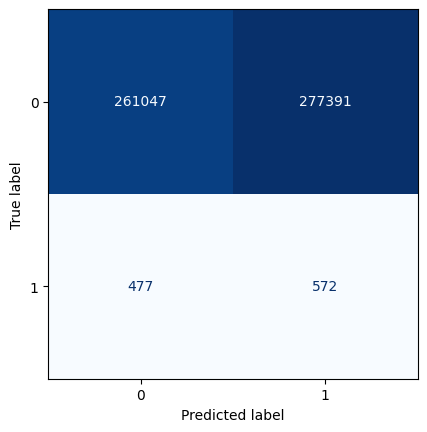

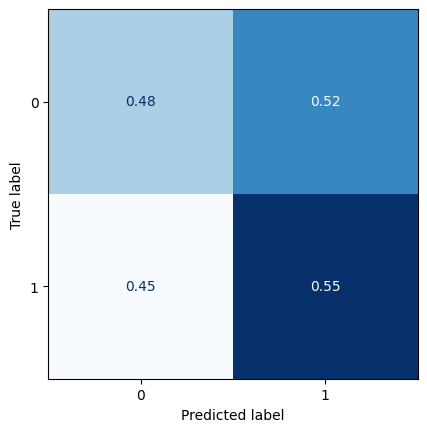

In [22]:
## Non imparas
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
#data1 = pd.read_csv(path4)
ConfusionMatrixDisplay(confusion_matrix(y_test_vec.reshape(-1,1), np.rint(t.reshape(-1,1)))).plot(colorbar=False,cmap=plt.cm.Blues, values_format='d')
ConfusionMatrixDisplay(confusion_matrix(y_test_vec.reshape(-1,1), np.rint(t.reshape(-1,1)), normalize='true')).plot(colorbar=False,cmap=plt.cm.Blues)
